# CPC251 - Project Part 2


#### Group Information

Group No: Climate4

- Member 1: Shivabala A/L Ganeish
- Member 2: Pavithran A/L Muthiah
- Member 3: Kishern A/L Prabagaran
- Member 4: Mohamad Azraei bin Johan


#### Import libraries

In [35]:
%config Completer.use_jedi=False # comment if not needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
)
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

#### Load the dataset

In [36]:
from google.colab import files
uploaded = files.upload()

Saving climate.csv to climate (2).csv


In [37]:
df = pd.read_csv('climate.csv')
df.head()

,Study,Run,vconst_corr,vconst_2,vconst_3,vconst_4,vconst_5,vconst_7,ah_corr,ah_bolus,...,efficiency_factor,tidal_mix_max,vertical_decay_scale,convect_corr,bckgrnd_vdc1,bckgrnd_vdc_ban,bckgrnd_vdc_eq,bckgrnd_vdc_psim,Prandtl,outcome
0,1,1,0.859036,0.927825,0.252866,0.298838,0.170521,0.735936,0.428325,0.567947,...,0.245675,0.104226,0.869091,0.997518,0.448620,0.307522,0.858310,0.796997,0.869893,0
1,1,2,0.606041,0.457728,0.359448,0.306957,0.843331,0.934851,0.444572,0.828015,...,0.616870,0.975786,0.914344,0.845247,0.864152,0.346713,0.356573,0.438447,0.512256,1
2,1,3,0.997600,0.373238,0.517399,0.504993,0.618903,0.605571,0.746225,0.195928,...,0.679355,0.803413,0.643995,0.718441,0.924775,0.315371,0.250642,0.285636,0.365858,1
3,1,4,0.783408,0.104055,0.197533,0.421837,0.742056,0.490828,0.005525,0.392123,...,0.471463,0.597879,0.761659,0.362751,0.912819,0.977971,0.845921,0.699431,0.475987,1
4,1,5,0.406250,0.513199,0.061812,0.635837,0.844798,0.441502,0.191926,0.487546,...,0.551543,0.743877,0.312349,0.650223,0.522261,0.043545,0.376660,0.280098,0.132283,1


#### Data preprocessing
Perform data preprocessing such as normalization, standardization, label encoding etc.
______________________________________________________________________________________
Description: We begin by checking for missing values, encoding if necessary, and scaling the numerical features.

In [38]:
# Check for missing values
df.isnull().sum()

,0
Study,0
Run,0
vconst_corr,0
vconst_2,0
vconst_3,0
vconst_4,0
vconst_5,0
vconst_7,0
ah_corr,0
ah_bolus,0


In [39]:
# Since all features are numerical, we impute missing values with the mean even though there is none
df.fillna(df.mean(), inplace=True)

In [40]:
# Drop identifier columns if not useful for prediction
df.drop(columns=['Study', 'Run'], inplace=True)

In [41]:
# Separate features and target
X = df.drop(columns=['outcome'])
y = df['outcome']

# Scale features only
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reconstruct DataFrame
X = pd.DataFrame(X_scaled, columns=X.columns)

#### Split the dataset
Split the dataset into training, validation and test sets.

In [42]:
# Features and target
X = df.drop(columns=['outcome'])
y = df['outcome']

# First split: 60% train, 40% temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Second split: 20% validation, 20% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Check distribution
print("Train set:", X_train.shape, y_train.value_counts(normalize=True).to_dict())
print("Validation set:", X_val.shape, y_val.value_counts(normalize=True).to_dict())
print("Test set:", X_test.shape, y_test.value_counts(normalize=True).to_dict())

Train set: (324, 18) {1: 0.9135802469135802, 0: 0.08641975308641975}
Validation set: (108, 18) {1: 0.9166666666666666, 0: 0.08333333333333333}
Test set: (108, 18) {1: 0.9166666666666666, 0: 0.08333333333333333}


#### Feature Selection
Perform feature selection to select the relevant features.
______________________________________________________________________________________
Description: We use correlation heatmap and feature importance via ExtraTreesRegressor to identify the top predictors for the target.

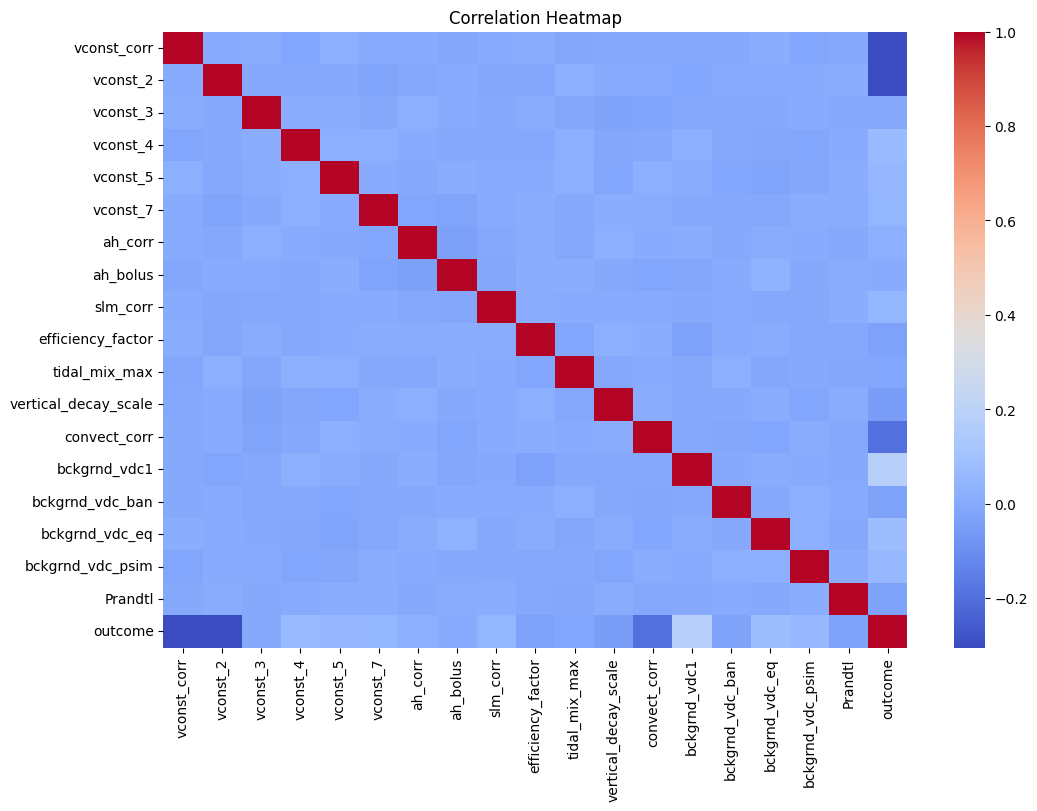

In [43]:
# Correlation heatmap

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.show()

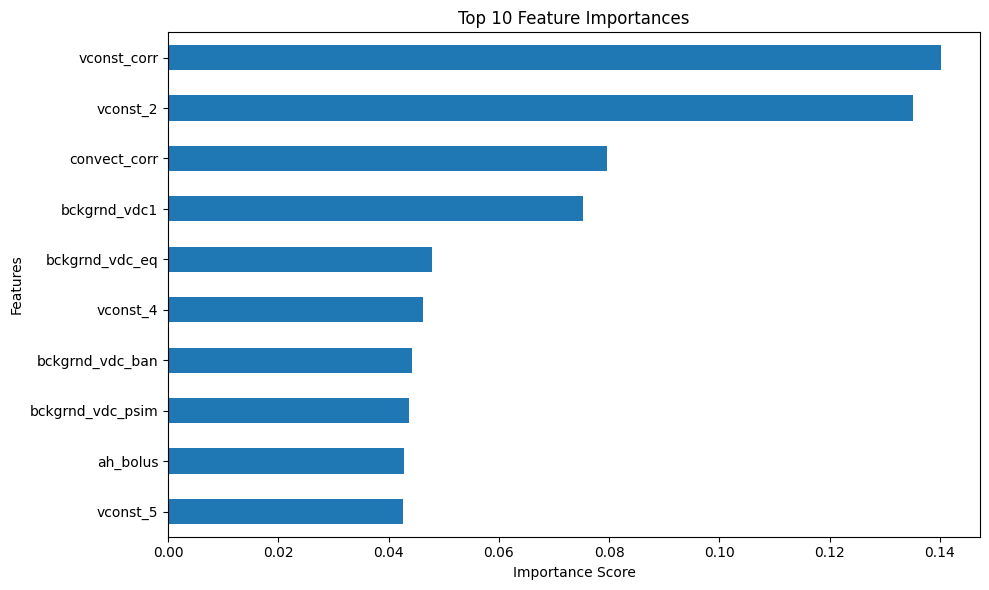

In [44]:
# Separate features and target
X = df.drop(columns=['outcome'])
y = df['outcome']

# Convert float-like binary values (e.g., 0.0 and 1.0) to integer class labels
df['outcome'] = df['outcome'].astype(int)
model = ExtraTreesClassifier()
model.fit(X, y)

# Get feature importances
importances = pd.Series(model.feature_importances_, index=X.columns)

# Top 10 features
top_features = importances.sort_values(ascending=False).head(10)


# Plot
plt.figure(figsize=(10, 6))
top_features.plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()  # Highest importance on top
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

#### Data modeling
Build the machine learning models. You must build atleast two (2) predictive models. One of the predictive models must be either Neural Network or Fuzzy Logic System.
______________________________________________________________________________________
Description: We have chosen Neural Network (Multilayer Perceptron) MLP Classifier and Support Vector Machine (SVM) as our predictive models. We implemented and evaluated both predictive models' performance on the climate.csv dataset. For MLP Classifier, the model was first trained using default parameters and evaluate the metrics of the model. Then, we fined tuned the model's hyperparameters using grid search with 5 folds cross validation and evaluate the metrics of the fine-tuned model. We visualized both tuned and untuned models' confusion metrics via 'ConfusionMatrixDisplay' class for each predictive models for better and clear understanding of the performance difference before and after fine tuning the models.

For the SVM model, first, the untuned model was implemented and evaluated using default settings. Then, a grid search was performed to optimize the hyperparameters and performance metrics have been evaluated. Same as MLP Classifier, We visualized both tuned and untuned models' confusion metrics via 'ConfusionMatrixDisplay' class for each predictive models for better and clear understanding of the performance difference before and after fine tuning the models.

####1st Model: Neural Network (MLP Classifier)




****** Neural Network (MLP Classifier) Before Tuning ******
Accuracy : 0.9537037037037037
Precision: 0.9501633986928105
Recall   : 0.9537037037037037
F1 Score : 0.9494195688225538

Confusion Matrix:
 [[ 5  4]
 [ 1 98]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.56      0.67         9
           1       0.96      0.99      0.98        99

    accuracy                           0.95       108
   macro avg       0.90      0.77      0.82       108
weighted avg       0.95      0.95      0.95       108



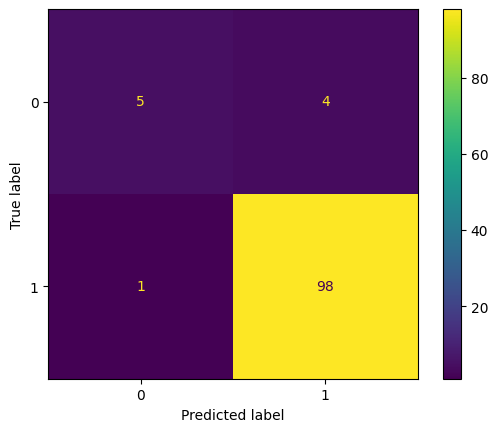

In [45]:
# Neural Network (MLP Classifier) before hyperparameter tuning

# Train and fit MLP Classifier
baseline = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='relu',
    solver='adam',
    max_iter=1500,
    random_state=42
)
baseline.fit(X_train, y_train)

# Predict on the test set
y_pred_base = baseline.predict(X_test)

# Neural Network (MLP Classifier) Metrics before tuning
print("****** Neural Network (MLP Classifier) Before Tuning ******")
print("Accuracy :", accuracy_score(y_test, y_pred_base))
print("Precision:", precision_score(y_test, y_pred_base, average='weighted', zero_division=0))
print("Recall   :", recall_score(y_test, y_pred_base, average='weighted'))
print("F1 Score :", f1_score(y_test, y_pred_base, average='weighted'))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_base))
print("\nClassification Report:\n", classification_report(y_test, y_pred_base, zero_division=0))

# Display Confusion Matrix
cm = confusion_matrix(y_test, y_pred_base)
cm_display = ConfusionMatrixDisplay(cm, display_labels=y.unique())
cm_display.plot(values_format='d')
plt.show()

Fitting 5 folds for each of 54 candidates, totalling 270 fits
****** Neural Network (MLP Classifier) After Tuning ******
Best params: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.005}
Accuracy : 0.9537
Precision: 0.9517
Recall   : 0.9537
F1 Score : 0.9525

Confusion Matrix:
 [[ 6  3]
 [ 2 97]]

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.67      0.71         9
           1       0.97      0.98      0.97        99

    accuracy                           0.95       108
   macro avg       0.86      0.82      0.84       108
weighted avg       0.95      0.95      0.95       108



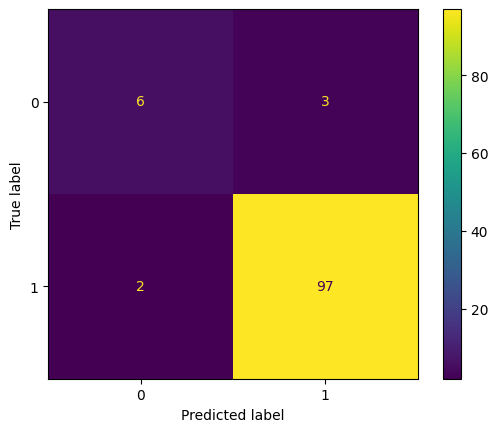

In [46]:
# Neural Network (MLP Classifier) after hyperparameter tuning

# Define hyperparameter grid for tuning MLPClassifier
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (150,)],
    'activation': ['relu', 'tanh'],
    'alpha': [1e-4, 1e-3, 1e-2],
    'learning_rate_init': [0.001, 0.005, 0.01]
}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=MLPClassifier(
        solver='adam',
        max_iter=500,
        random_state=42
    ),
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2
)

# Fit the grid search on the training data
grid_search.fit(X_train, y_train)

# Use the best model found from grid search
best_mlp = grid_search.best_estimator_
y_pred_tuned = best_mlp.predict(X_test)

# Neural Network (MLP Classifier) Metrics after tuning
print("****** Neural Network (MLP Classifier) After Tuning ******")
print("Best params:", grid_search.best_params_)
print(f"Accuracy : {accuracy_score(y_test, y_pred_tuned):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_tuned, average='weighted'):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred_tuned, average='weighted'):.4f}")
print(f"F1 Score : {f1_score(y_test, y_pred_tuned, average='weighted'):.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_tuned))
print("\nClassification Report:\n", classification_report(y_test, y_pred_tuned, zero_division=0))

# Display Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tuned)
cm_display = ConfusionMatrixDisplay(cm, display_labels=y.unique())
cm_display.plot(values_format='d')
plt.show()

###2nd Model: Support Vector Machine

****** Support Vector Machine Before Tuning ******

Accuracy: 0.9166666666666666
Precision: 0.9166666666666666
Recall: 1.0
F1 Score: 0.9565217391304348

Confusion Matrix:
 [[ 0  9]
 [ 0 99]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.92      1.00      0.96        99

    accuracy                           0.92       108
   macro avg       0.46      0.50      0.48       108
weighted avg       0.84      0.92      0.88       108



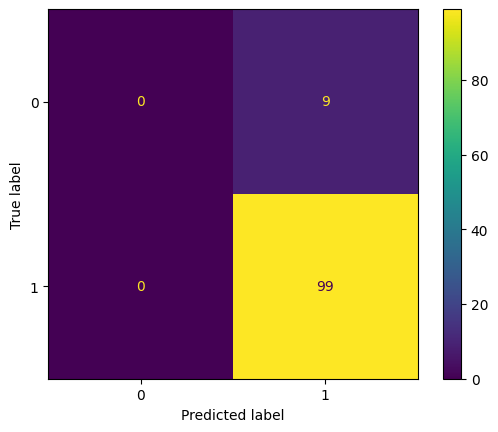

In [47]:
# Initialize and train SVM model
svm_model = SVC()
svm_model.fit(X_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_test)

# Evaluate model
print("****** Support Vector Machine Before Tuning ******")
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='binary', zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='binary', zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred, average='binary', zero_division=0))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels=y.unique())
cm_display.plot(values_format='d')
plt.show()


****** Support Vector Machine After Tuning ******

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy: 0.9629629629629629
Precision: 0.9611650485436893
Recall: 1.0
F1 Score: 0.9801980198019802

Confusion Matrix:
 [[ 5  4]
 [ 0 99]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.56      0.71         9
           1       0.96      1.00      0.98        99

    accuracy                           0.96       108
   macro avg       0.98      0.78      0.85       108
weighted avg       0.96      0.96      0.96       108



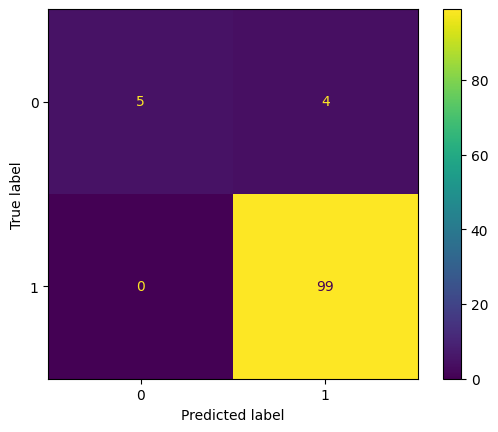

In [48]:
# Define hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

# Set up grid search with SVC
grid_search = GridSearchCV(SVC(), param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)

# Evaluate tuned model
print("****** Support Vector Machine After Tuning ******")
print("\nBest Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_tuned))
print("Precision:", precision_score(y_test, y_pred_tuned, average='binary', zero_division=0))
print("Recall:", recall_score(y_test, y_pred_tuned, average='binary', zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred_tuned, average='binary', zero_division=0))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_tuned))
print("\nClassification Report:\n", classification_report(y_test, y_pred_tuned, zero_division=0))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred_tuned)
cm_display = ConfusionMatrixDisplay(cm, display_labels=y.unique())
cm_display.plot(values_format='d')
plt.show()


#### Evaluate the models
Perform a comparison between the predictive models. <br>
Report the accuracy, recall, precision and F1-score measures as well as the confusion matrix if it is a classification problem. <br>
Report the R2 score, mean squared error and mean absolute error if it is a regression problem.
______________________________________________________________________________________
Description:

## Comparison Between Predictive Models

To identify the most effective predictive model for our classification task, we evaluated two models:
- Multi-Layer Perceptron (MLP)
- Support Vector Machine (SVM)

Both models were assessed using standard classification metrics: Accuracy, Precision, Recall, F1-Score, and the Confusion Matrix.

We compare these metrics side by side to determine which model provides the best balance of predictive performance.

In [49]:
# Evaluation of the tuned MLP and SVM models

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd

# -------MLP Model---------
# Define hyperparameter grid for tuning MLPClassifier
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (150,)],
    'activation': ['relu', 'tanh'],
    'alpha': [1e-4, 1e-3, 1e-2],
    'learning_rate_init': [0.001, 0.005, 0.01]
}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=MLPClassifier(
        solver='adam',
        max_iter=500,
        random_state=42
    ),
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2
)

# Fit the grid search on the training data
grid_search.fit(X_train, y_train)

# Use the best model found from grid search
best_mlp = grid_search.best_estimator_
y_pred_tuned = best_mlp.predict(X_test)

# Evaluate MLP Model
mlp_accuracy = accuracy_score(y_test, y_pred_tuned)
mlp_precision = precision_score(y_test, y_pred_tuned, average='weighted', zero_division=0)
mlp_recall = recall_score(y_test, y_pred_tuned, average='weighted', zero_division=0)
mlp_f1 = f1_score(y_test, y_pred_tuned, average='weighted', zero_division=0)
mlp_conf_matrix = confusion_matrix(y_test, y_pred_tuned)

# Display results MLP
print("MLP Model:")
print(f"Accuracy: {mlp_accuracy}")
print(f"Precision: {mlp_precision}")
print(f"Recall: {mlp_recall}")
print(f"F1-score: {mlp_f1}")
print("Confusion Matrix:")
print(mlp_conf_matrix)

# -------SVM Model-------
# Define hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

# Set up grid search with SVC
grid_search = GridSearchCV(SVC(), param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)


# Evaluate SVM Model
svm_accuracy = accuracy_score(y_test, y_pred_tuned)
svm_precision = precision_score(y_test, y_pred_tuned, average='weighted', zero_division=0)
svm_recall = recall_score(y_test, y_pred_tuned, average='weighted', zero_division=0)
svm_f1 = f1_score(y_test, y_pred_tuned, average='weighted', zero_division=0)
svm_conf_matrix = confusion_matrix(y_test, y_pred_tuned)

# Display results svm
print("\nSVM Model:")
print(f"Accuracy: {svm_accuracy}")
print(f"Precision: {svm_precision}")
print(f"Recall: {svm_recall}")
print(f"F1-score: {svm_f1}")
print("Confusion Matrix:")
print(svm_conf_matrix)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
MLP Model:
Accuracy: 0.9537037037037037
Precision: 0.9516666666666667
Recall: 0.9537037037037037
F1-score: 0.9524583702827866
Confusion Matrix:
[[ 6  3]
 [ 2 97]]

SVM Model:
Accuracy: 0.9629629629629629
Precision: 0.964401294498382
Recall: 0.9629629629629629
F1-score: 0.9580386610089581
Confusion Matrix:
[[ 5  4]
 [ 0 99]]


####Model Analysis
------------------------------------

In [50]:
# Summary Table
comparison_df = pd.DataFrame({
    'Model': ['MLP', 'SVM'],
    'Accuracy': [mlp_accuracy, svm_accuracy],
    'Precision': [mlp_precision, svm_precision],
    'Recall': [mlp_recall, svm_recall],
    'F1-score': [mlp_f1, svm_f1]
})
print("\nComparison of the Predictive Models:")
print(comparison_df.to_string(index=False))


Comparison of the Predictive Models:
Model  Accuracy  Precision   Recall  F1-score
  MLP  0.953704   0.951667 0.953704  0.952458
  SVM  0.962963   0.964401 0.962963  0.958039


##Multi-Layer Perceptron (MLP)

- Accuracy: 95.37% – High overall predictive performance

- Precision: 95.17% – Slightly more false positives than SVM

- Recall: 95.37% – Identified most of the actual positive instances

- F1-Score: 95.25% – Balanced precision and recall

- Confusion matrix: [[ 6  3][ 2 97]]

Advantages:

- Strong, consistent performance across all metrics

- Effective at capturing both positive and negative instances

- Handles non-linear patterns well due to its neural architecture

Considerations:

- Slightly lower accuracy and F1-score compared to SVM

- Training may require more time and tuning due to model complexity

##Support Vector Machine (SVM)

- Accuracy: 96.30% – Best overall predictive performance

- Precision: 96.44% – Fewer false positives compared to MLP

- Recall: 96.30% – Successfully captured almost all actual positives

- F1-Score: 95.80% – Best harmonic mean of precision and recall

- Confusion Matrix: [[ 5  4][ 0 99]]

Advantages:

- Best performance across all metrics

- Excellent generalization with minimal overfitting

- Very precise with few false positives

Considerations:

- May be slower for large datasets

- Requires careful parameter tuning (kernel, C, gamma)

###Conclusion

Based on the evaluation results:

- The SVM model offers better overall performance with the highest accuracy, precision, recall, and F1-score. It also made no false negatives, making it ideal for applications where missing a positive case is critical.

- The MLP model, while also strong, had slightly lower scores and a small number of false negatives and positives.

Recommendation: Use SVM if optimal classification accuracy and reliability are the priority.

Consider MLP if neural network scalability or multi-class extension is a key consideration.